In [34]:
import math
import numpy as np
from tqdm import tqdm

In [56]:
#warning settings
np.seterr(all="ignore") #ignore np warnings, the output will be nan or inf and will be handled correctly in the code. (using np.errstate slows down the code)

{'divide': 'ignore', 'over': 'ignore', 'under': 'ignore', 'invalid': 'ignore'}

In [83]:
# Configuration
TRAIN_TEST_RATIO=0.8
PROBLEM_NUMBER=7

### Data Loading and Data Preprocessing

In [84]:
# Load problem data with context manager protocol
with np.load(f'../data/problem_{PROBLEM_NUMBER}.npz') as problem:
    x_1 = problem['x']
    y_1 = problem['y']

# Shuffle the data
permutation = np.random.permutation(len(y_1))
x_1 = x_1[:, permutation]
y_1 = y_1[permutation]

# Determine train test split sizes
problem_len=len(y_1)
train_size=int(TRAIN_TEST_RATIO*problem_len)

# Split data
x_train = x_1[:, :train_size]
y_train = y_1[:train_size]

x_test = x_1[:, train_size:]
y_test = y_1[train_size:]


# Print dataset information
print(f"Problem number: {PROBLEM_NUMBER}, variables: {x_1.shape[0]}, train size: {train_size}, test size: {problem_len-train_size}")

print(f"Training data: x shape {x_train.shape}, y shape {y_train.shape}")
print(f"Testing data: x shape {x_test.shape}, y shape {y_test.shape}")



Problem number: 7, variables: 2, train size: 4000, test size: 1000
Training data: x shape (2, 4000), y shape (4000,)
Testing data: x shape (2, 1000), y shape (1000,)


### Numpy functions definition

In [89]:
unary_ops = [
    np.negative,
    np.abs,
    np.sqrt,
    np.exp,
    np.log,
    np.sin,
    np.cos,
    np.tan,
    # np.arcsin,
    # np.arccos,
    # np.arctan,
    # np.sinh,
    # np.cosh,
    # np.tanh,
    np.square,
    np.cbrt,
    np.reciprocal,

    np.ceil,
    np.floor
]

binary_ops = [
    np.add,
    np.subtract,
    np.multiply,
    np.divide,
    np.power,
    # np.maximum,
    # np.minimum,
    # np.mod
]

### Symbolic Regression Class

In [90]:
from tree import Tree

class SymbolicRegression:
    def __init__(self, population_per_island,island_num, max_generations, mutation_rate, elitism_size, grow_full_ratio,max_mutations,migration_rate,collapse_rate):
        self.population_per_island = population_per_island
        self.island_num = island_num
        self.max_generations = max_generations
        self.mutation_rate = mutation_rate
        self.elitism_size = elitism_size
        self.grow_full_ratio = grow_full_ratio
        self.max_mutations = max_mutations
        self.unary_ops = unary_ops
        self.binary_ops = binary_ops
        self.migration_rate=migration_rate
        self.best_fitness_history = []
     
        self.population = [None] * island_num
        self.collapse_rate=collapse_rate

        for j in range(island_num):
            self.population[j] = np.array([
                Tree("grow") if i < int(population_per_island * self.grow_full_ratio) else Tree("full") for i in range(population_per_island)
            ])
        
        
         


    # Parents selection methods
    def select_parents_fitness_proportional(self, n_elems=2, epsilon=1e-10,island=0):
        """
        Fitness proportional selection method.
        Randomly selects n_elems individuals based on their fitness.
        Individuals with lower fitness have an higher probability to be selected.
        Premature convergence if few individuals have significantly better fitness than others.
        n_elems: number of elements to select.
        epsilon: small value to avoid division by zero.
        island: on which island the selection should be done.
        """
        fitnesses = [tree.fitness for tree in self.population[island]]
        inverted_fitnesses = [1 / (fitness + epsilon) for fitness in fitnesses]  # avoid division by zero
        probabilities = inverted_fitnesses / sum(inverted_fitnesses)
        parent1, parent2 = np.random.choice(self.population[island], size=n_elems, p=probabilities, replace=False)
        return parent1, parent2
    
    

    def select_parents_rank_based(self, n_elems=2,island=0,exponential=False):
        """
        Rank-based selection method.
        Assigns probabilities based on inversed ranks instead of absolute fitness values.
        n_elems: number of elements to select.
        island: on which island the selection should be done.
        exponential: if True, the ranks are raised to the power of the exponential parameter.
        """
        fitnesses = np.array([tree.fitness for tree in self.population[island]])
        ranks = np.argsort(fitnesses)
        if exponential:
            ranks = ranks**exponential
        inversed_ranks = len(fitnesses) - ranks
        probabilities = inversed_ranks / np.sum(inversed_ranks)
        return np.random.choice(self.population[island], n_elems, p=probabilities, replace=False)
    
    def select_parents_tournament(self,island=0):
        """
        Tournament selection method.
        Randomly selects a subset of the population and selects the best individual from the subset.
        """
        tournament_size = 5
        tournament = list(np.random.choice(self.population[island], tournament_size, replace=True))
        tournament.sort(key=lambda x: x.fitness)
        return tournament[0], tournament[1]
    
    def select_parents(self, island, method="rank"):
        """
        Select parents based on the specified method.
        island: on which island the selection should be done
        method: which parent selection method to use. Default is "rank". Options are "rank", "fitness_proportional", "tournament".
        """
        if method == "rank":
            return self.select_parents_rank_based(island=island)
        elif method == "fitness_proportional":
            return self.select_parents_fitness_proportional(island=island)
        elif method == "tournament":
            return self.select_parents_tournament(island=island)
        else:
            return self.select_parents_rank_based(island=island)
            

    
    # Mutation methods
    def mutate(self, tree):
        if np.random.rand() < 0.5:
            tree.mutate_subtree()
        else:
            mutations = np.random.randint(1, self.max_mutations+1)
            tree.mutate_single_node(num_mutations=mutations)
        
       


    # Offsprings generation via mutation and crossover
    def offspring_generation(self,island):
        new_population = np.array([])

        # Elitism   
        elite_individuals = self.population[island][:self.elitism_size]
        new_population = elite_individuals

        # Main loop
        while len(new_population) < self.population_per_island//2: 
            parent1, parent2 = self.select_parents(island=island)
            # generate offsprings (one in mutation, two in crossover)
            offsprings = np.array([])

            if(np.random.rand() < self.mutation_rate):
                parent_clone = parent1.copy_tree()
                self.mutate(parent_clone)
              
                parent_clone.compute_fitness()
                #if the fitness is valid 
                if(parent_clone.fitness is not np.inf and parent_clone.fitness is not np.nan):
                    #to not re-add the same tree if the mutation was not possible (e.g. the tree is already a leaf and other edge cases)
                    if( parent_clone.fitness!=parent1.fitness):
                        offsprings = np.append(offsprings, [parent_clone])

            else:    
                offspring1, offspring2 = parent1.crossover(parent2)
                if(offspring1 is not None and offspring2 is not None):
               
                    offspring1.compute_fitness()
                    offspring2.compute_fitness()

                    offsprings = np.append(offsprings, [offspring1, offspring2])

            # Collapse branch
            for offsp in offsprings:
                if(np.random.rand() < self.collapse_rate):
                    #clone the tree and collapse the branch
                    tree_clone = offsp.copy_tree()
                
                    Tree.collapse_branch(tree_clone.root,force_collapse=True)
                    tree_clone.compute_fitness()
                    #if the fitness is not nan or inf after collapsing
                    if(tree_clone.fitness is not None or tree_clone.fitness is not np.inf and tree_clone.fitness is not np.nan):
                            offsp = tree_clone

            new_population = np.concatenate((new_population, offsprings))
                
        return new_population
    
    # Genetic Algorithm: Evolutionary Process
    def evolve(self,verbose=False,use_std_operators=False):
        best_tree_island = np.full(self.island_num, None, dtype=object)
        best_fitness_island = np.full(self.island_num, np.inf)
        global_best_fitness = np.inf
        global_best_tree = None
        take_over = np.full(self.island_num, False)
        # self.population_per_island.sort(key=lambda x: x.fitness) 
        #numpy sort of population over fitness
        for i in range(self.island_num):
            self.population[i].sort()
      


        for generation in tqdm(range(self.max_generations)):
           
            for i in range(self.island_num):
                if take_over[i]:
                    
                    self.population[i] = np.unique(self.population[i])
                    new_trees = np.array([Tree("grow") for _ in range(self.population_per_island-len(self.population[i]))])
                 
                    self.population[i] = np.concatenate((self.population[i],new_trees))
                    self.population[i].sort()
                

                if np.random.rand()<self.migration_rate and self.island_num>1:
                    #pick a random island to migrate to 
                    island_to_migrate = np.random.randint(0,self.island_num)
                    #select a random number from 0 to the population size of the current island
                    random_index = np.random.randint(0,len(self.population[i]))
                    
                    self.population[island_to_migrate]=np.append(self.population[island_to_migrate],self.population[i][random_index])
                    #remove the tree from the current island
                    self.population[i]=np.delete(self.population[i],random_index)
                    

                    if(verbose):
                        print(f"Migration at {generation} gen from {i} to {island_to_migrate}")


                new_population=self.offspring_generation(island=i)
                    
                self.population[i]=np.concatenate((self.population[i],new_population))
                self.population[i].sort()
                
                generation_best_fitness_island = self.population[i][0].fitness

                if generation_best_fitness_island < best_fitness_island[i]:
                    best_fitness_island[i] = generation_best_fitness_island
                    best_tree_island[i] = self.population[i][0]
                    

                    if(best_fitness_island[i] < global_best_fitness):
                        global_best_fitness = best_fitness_island[i]
                        global_best_tree = best_tree_island[i]
                        self.best_fitness_history.append((best_fitness_island[i], generation))


                #trim the population to the best island_population
                self.population[i] = self.population[i][:self.population_per_island]

                
                
                n_best = [elem for elem in self.population[i] if elem.fitness == self.population[i][0].fitness]
                take_over[i] = False
                if len(n_best) > 0.5 * self.population_per_island:
                        take_over[i] = True
                             
                if(generation%100==0 and verbose):
                        print(f"Generation {generation + 1}, Island: {i}, Best Fitness: {best_fitness_island[i]}, Best Formula: {best_tree_island[i].to_np_formula(use_std_operators=use_std_operators)}")
            
                if global_best_fitness <= 1e-33:
                    break   

            if(generation%100==0 and not verbose):
                print(f"Generation {generation + 1}, Best Fitness: {global_best_fitness}, Best Formula: {global_best_tree.to_np_formula(use_std_operators=use_std_operators)}")

        return global_best_tree, global_best_fitness

### Problem Definition and Symbolic Regression Initialization

In [91]:
# --ISLAND SETTINGS--
ISLAND_POPULATION = 70
ISLAND_NUM = 4
MIGRATION_RATE = 0.0005


# --TREE SETTINGS--
TREE_MAX_DEPTH = 4
TREE_SPAWN_DEPTH = 3 #the max depth at which the tree will be spawned, they can grow up to TREE_MAX_DEPTH



# --GENETIC ALGORITHM SETTINGS--
MAX_GENERATIONS = 5000
ELITISM_SIZE = 1
VAR_NUM = x_train.shape[0]
CONST_RANGE = 10 # Constats will be in the range [-CONST_RANGE, CONST_RANGE]
MAX_MUTATIONS = 3  # Maximum number of mutations in a single mutation operation
MUTATION_RATE = 0.35
GROW_FULL_RATIO = 0.95
COLLAPSE_RATE = 0.3

# --DEPTH CHECK--
min_depth_data = math.ceil(math.log(x_train.shape[0],2))
if(TREE_SPAWN_DEPTH<min_depth_data):
    TREE_SPAWN_DEPTH = min_depth_data
    print(f"Spawn depth too low, set to {TREE_SPAWN_DEPTH}")

if(TREE_MAX_DEPTH<TREE_SPAWN_DEPTH):
    TREE_MAX_DEPTH = TREE_SPAWN_DEPTH+1
    print(f"Max depth too low, set to {TREE_MAX_DEPTH}")


Tree.set_params(unary_ops, binary_ops, VAR_NUM, CONST_RANGE,TREE_MAX_DEPTH,TREE_SPAWN_DEPTH, x_train, y_train, x_test, y_test)
regressor = SymbolicRegression(
    ISLAND_POPULATION,
    ISLAND_NUM,
    MAX_GENERATIONS,
    MUTATION_RATE,
    ELITISM_SIZE,
    GROW_FULL_RATIO,
    MAX_MUTATIONS,
    MIGRATION_RATE,
    COLLAPSE_RATE
    
)
#print the trees


### Algorithm Execution and Results Computation

In [92]:

# Execute the algorithm
best_tree, best_fitness = regressor.evolve(use_std_operators=False,verbose=True)   #use_std_operators=True to use standard operators (+,-,*,/), use verbose=True to print the best tree for each island every 50 iterations

print(f"\nTrain Fitness: {best_fitness}")
# Calculate the fitness on original data
best_tree.compute_fitness(test="test")




print(f"Test Fitness: {best_tree.fitness}")
print(f"Train-Test Discrepancy: {best_fitness-best_tree.fitness}")
best_tree.compute_fitness(test="all")
print(f"Global Fitness: {best_tree.fitness}")


#Print the best tree
print(f"Best Fitness History: {[tup[0] for tup in regressor.best_fitness_history]}, changed {len(regressor.best_fitness_history)} times\n")

print(f"Best Formula: {best_tree.to_np_formula(use_std_operators=False)}\n")
print(f"Best Formula with standard operators: {best_tree.to_np_formula(use_std_operators=True)}")



  0%|          | 0/5000 [00:00<?, ?it/s]

Generation 1, Island: 0, Best Fitness: 716.2613264035701, Best Formula: np.divide(np.multiply(x[1], 9.012982427389339), np.divide(np.negative(-0.7138628371007663), x[0]))
Generation 1, Island: 1, Best Fitness: 698.9687492725227, Best Formula: np.exp(np.multiply(x[0], x[1]))
Generation 1, Island: 2, Best Fitness: 698.9687492725227, Best Formula: np.exp(np.multiply(x[1], x[0]))


  0%|          | 2/5000 [00:00<18:58,  4.39it/s]

Generation 1, Island: 3, Best Fitness: 698.9687492725227, Best Formula: np.power(np.exp(x[0]), x[1])


  2%|▏         | 101/5000 [00:18<12:34,  6.49it/s]

Generation 101, Island: 0, Best Fitness: 379.8324606005791, Best Formula: np.power(4.445774612028156, np.multiply(x[0], x[1]))
Generation 101, Island: 1, Best Fitness: 533.7692732420705, Best Formula: np.exp(np.multiply(x[0], np.multiply(np.log(np.add(7.030050672469294, 4.290434175876939)), np.sin(x[1]))))
Generation 101, Island: 2, Best Fitness: 379.44011549924045, Best Formula: np.power(np.power(np.subtract(np.divide(1.0585725835055158, 5.414210355307798), np.add(np.divide(5.414210355307798, -8.921189187095111), -4.09485986890842)), x[1]), np.divide(x[0], 1.0585725835055158))
Generation 101, Island: 3, Best Fitness: 379.67725418243936, Best Formula: np.power(np.exp(x[0]), np.multiply(np.cbrt(3.4251361031813055), x[1]))


  4%|▍         | 201/5000 [00:36<14:07,  5.67it/s]

Generation 201, Island: 0, Best Fitness: 379.46918588639414, Best Formula: np.power(np.power(4.495527316084594, x[1]), x[0])
Generation 201, Island: 1, Best Fitness: 379.45949900903184, Best Formula: np.power(np.power(np.subtract(7.702087224752795, np.subtract(7.763968538715581, np.subtract(8.864442622962954, 4.308962451898829))), x[1]), x[0])
Generation 201, Island: 2, Best Fitness: 379.44011549924045, Best Formula: np.power(np.power(np.subtract(np.divide(1.0585725835055158, 5.414210355307798), np.add(np.divide(5.414210355307798, -8.921189187095111), -4.09485986890842)), x[1]), np.divide(x[0], 1.0585725835055158))
Generation 201, Island: 3, Best Fitness: 379.4491112689994, Best Formula: np.power(np.exp(x[0]), np.multiply(np.cbrt(np.multiply(np.log(9.359385370046539), np.cbrt(3.4251361031813055))), x[1]))


  5%|▍         | 229/5000 [00:42<14:39,  5.42it/s]


KeyboardInterrupt: 

### Best Tree Drawing

Collapsed formula: np.subtract(x[1], np.divide(np.add(np.multiply(-3.7176133491516232, x[0]), np.multiply(3.7181064589095936, x[1])), -5.353100666015106))

Tree drawing (after collapsing):


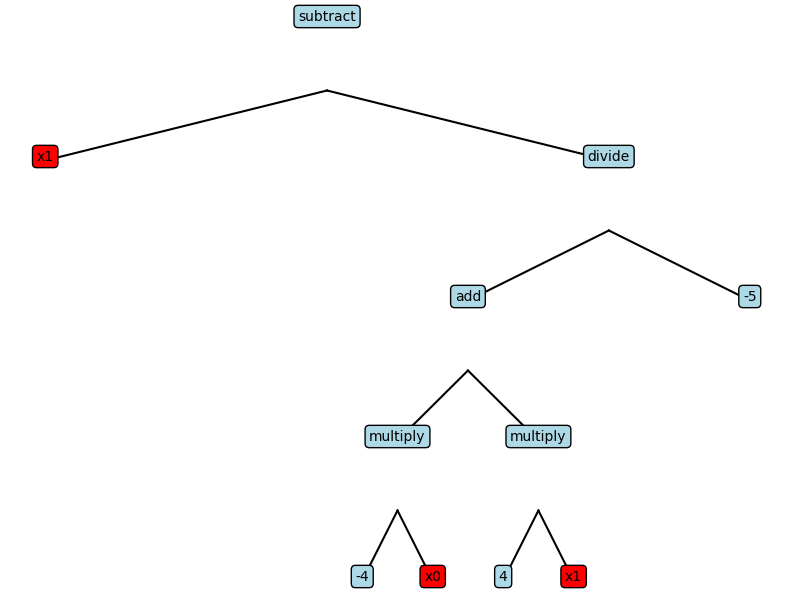

In [ ]:
tree_clone = best_tree.copy_tree()
Tree.collapse_branch(tree_clone.root,0,force_collapse=True)
tree_clone.compute_fitness()           
if(tree_clone.fitness is not None or tree_clone.fitness is not np.inf and tree_clone.fitness is not np.nan):
                    best_tree = tree_clone


print(f"Collapsed formula: {best_tree.to_np_formula(use_std_operators=False)}\n") #use_std_operators=True to use standard operators (+,-,*,/)
print("Tree drawing (after collapsing):")
best_tree.add_drawing()


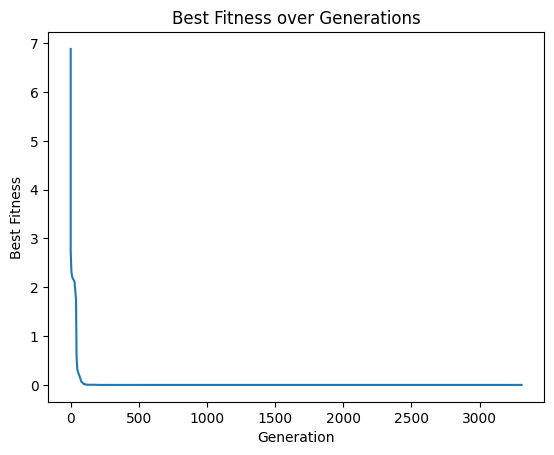

In [ ]:
#Print graph of best fitness over generations
import matplotlib.pyplot as plt
plt.plot([tup[1] for tup in regressor.best_fitness_history], [tup[0] for tup in regressor.best_fitness_history])
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.title('Best Fitness over Generations')
plt.show()